<a href="https://colab.research.google.com/github/gisynw/ssj-302/blob/main/docs/Lectures/WWeek08_Arcpy_Instructor.ipynb" target="_blank">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" style="height: 30px;"/>
</a>
&nbsp &nbsp
<a href="./Week08_Arcpy_Instructor.ipynb" target="_blank"> 
  <img src="https://img.icons8.com/?size=100&id=108635&format=png&color=000000" alt="Download" style="height: 40px;"/>
 </a>

<center>
    <h2 style="color:  #526cfe; font-family: Arial, sans-serif; font-size: 32px; padding: 10px;">
        Week 8: Spatial Analysis in Python
    </h2>
</center>

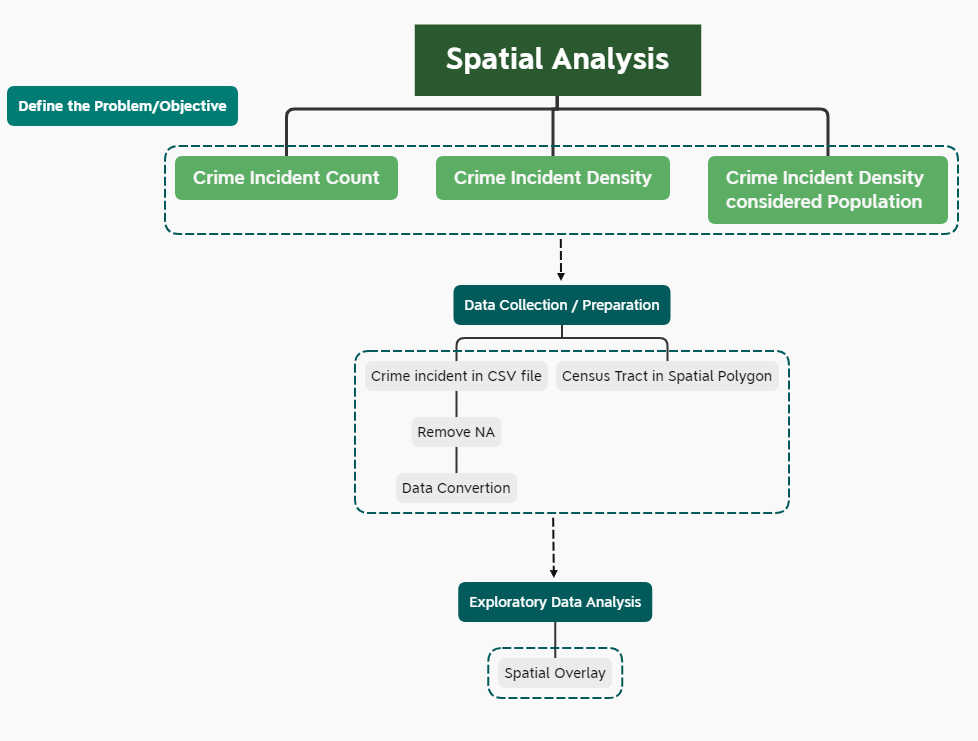

## 1. Data Collection 

### 1.1 Downlaod Data

[Crime Incident Report 2022](https://data.boston.gov/dataset/crime-incident-reports-august-2015-to-date-source-new-system)

[Censsu Tract 2020 Boston](https://data.boston.gov/dataset/2020-census-tracts-in-boston)

Some census tract are removed due to having a populatio of zero. 

In [2]:
import os
import pandas as pd
from arcgis import GIS
from arcgis.features import GeoAccessor, GeoSeriesAccessor

### 1.2 Load Data

In [6]:
paths = os.path.join(os.getcwd(),  "CrimeIncident.csv")
paths

'F:\\Clark_Universiy\\Clark_Teaching\\Git_Repo\\ssj-302\\docs\\Lectures\\Week08_spatailAnalysis\\Week08_SpatialAnalysis\\CrimeIncident.csv'

In [7]:
csv_file = pd.read_csv(paths) 
csv_file.head()

[7]:1: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.


,INCIDENT_NUMBER,OFFENSE_CODE,OFFENSE_CODE_GROUP,OFFENSE_DESCRIPTION,DISTRICT,REPORTING_AREA,SHOOTING,OCCURRED_ON_DATE,YEAR,MONTH,DAY_OF_WEEK,HOUR,UCR_PART,STREET,Lat,Long,Location
0,222076257,619,NaN,LARCENY ALL OTHERS,D4,167,0,2022-01-01 00:00:00,2022,1,Saturday,0,NaN,HARRISON AVE,42.339542,-71.069409,"(42.33954198983014, -71.06940876967543)"
1,222053099,2670,NaN,HARASSMENT/ CRIMINAL HARASSMENT,A7,,0,2022-01-01 00:00:00,2022,1,Saturday,0,NaN,BENNINGTON ST,42.377246,-71.032597,"(42.37724638479816, -71.0325970804128)"
2,222039411,3201,NaN,PROPERTY - LOST/ MISSING,D14,778,0,2022-01-01 00:00:00,2022,1,Saturday,0,NaN,WASHINGTON ST,42.349056,-71.150498,"(42.34905600030506, -71.15049849975023)"
3,222011090,3201,NaN,PROPERTY - LOST/ MISSING,B3,465,0,2022-01-01 00:00:00,2022,1,Saturday,0,NaN,BLUE HILL AVE,42.284826,-71.091374,"(42.28482576580488, -71.09137368938802)"
4,222062685,3201,NaN,PROPERTY - LOST/ MISSING,B3,465,0,2022-01-01 00:00:00,2022,1,Saturday,0,NaN,BLUE HILL AVE,42.284826,-71.091374,"(42.28482576580488, -71.09137368938802)"


In [8]:
csv_file = pd.read_csv(paths,dtype={0: str}) 
print(len(csv_file.index))
csv_file.head(5)

73852


,INCIDENT_NUMBER,OFFENSE_CODE,OFFENSE_CODE_GROUP,OFFENSE_DESCRIPTION,DISTRICT,REPORTING_AREA,SHOOTING,OCCURRED_ON_DATE,YEAR,MONTH,DAY_OF_WEEK,HOUR,UCR_PART,STREET,Lat,Long,Location
0,222076257,619,NaN,LARCENY ALL OTHERS,D4,167,0,2022-01-01 00:00:00,2022,1,Saturday,0,NaN,HARRISON AVE,42.339542,-71.069409,"(42.33954198983014, -71.06940876967543)"
1,222053099,2670,NaN,HARASSMENT/ CRIMINAL HARASSMENT,A7,,0,2022-01-01 00:00:00,2022,1,Saturday,0,NaN,BENNINGTON ST,42.377246,-71.032597,"(42.37724638479816, -71.0325970804128)"
2,222039411,3201,NaN,PROPERTY - LOST/ MISSING,D14,778,0,2022-01-01 00:00:00,2022,1,Saturday,0,NaN,WASHINGTON ST,42.349056,-71.150498,"(42.34905600030506, -71.15049849975023)"
3,222011090,3201,NaN,PROPERTY - LOST/ MISSING,B3,465,0,2022-01-01 00:00:00,2022,1,Saturday,0,NaN,BLUE HILL AVE,42.284826,-71.091374,"(42.28482576580488, -71.09137368938802)"
4,222062685,3201,NaN,PROPERTY - LOST/ MISSING,B3,465,0,2022-01-01 00:00:00,2022,1,Saturday,0,NaN,BLUE HILL AVE,42.284826,-71.091374,"(42.28482576580488, -71.09137368938802)"


### 1.3 Remove NA

In [9]:
full_crime = csv_file.dropna(subset=['Lat'])
print(len(full_crime.index))

70044


### 1.4 Save the csv to a temporary file

In [11]:
incidents = r"Incidents.csv"  # Temporary file path for cleaned CSV
full_crime.to_csv(incidents, index=False)
arcpy.management.MakeTableView(incidents, 'Incidents.csv')

<Result 'Incidents'>

### 1.5 Convert data from csv to shapefile

In [12]:
output_folder = os.getcwd()  # Folder to save the shapefile
crime_shp = os.path.join(output_folder, "CrimeInct.shp") 

In [13]:
spatial_ref = arcpy.SpatialReference(4326)

In [14]:
incidents = r"Incidents"
arcpy.management.XYTableToPoint(incidents, crime_shp, x_field="Long", y_field="Lat", coordinate_system=spatial_ref)

<Result 'F:\\Clark_Universiy\\Clark_Teaching\\Git_Repo\\ssj-302\\docs\\Lectures\\Week08_spatailAnalysis\\Week08_SpatialAnalysis\\CrimeInct.shp'>

## 2. Explortary Spatial Data Analysis

### 2.1 Spatial join

In [15]:
inct_shp = r"CrimeInct.shp"
ct_shp = r"2020_Boston_CT.shp"
output_shp = r"CT_inct_total.shp"

In [16]:
arcpy.analysis.SpatialJoin(
    target_features=ct_shp,
    join_features=inct_shp,
    out_feature_class=output_shp,
    join_operation = "JOIN_ONE_TO_ONE",
    join_type="KEEP_COMMON",
    match_option="CONTAINS"
)

<Result 'F:\\Clark_Universiy\\Clark_Teaching\\Git_Repo\\ssj-302\\docs\\Lectures\\Week08_spatailAnalysis\\Week08_SpatialAnalysis\\CT_inct_total.shp'>

## 3. Spatial Pattern

### 3.1 Visualize Crime Incident counts with SEDF 

#### Q1: How many incidents are there in each census tract in Boston?

In [17]:
polygon_shapefile = r"CT_inct_total.shp"
crime_total = pd.DataFrame.spatial.from_featureclass(polygon_shapefile)

[Spatial Plot](https://developers.arcgis.com/python/latest/guide/visualizing-data-with-the-spatially-enabled-dataframe/)

[cmap in matplotlib](https://matplotlib.org/stable/users/explain/colors/colormaps.html)

In [18]:
map_widget = crime_total.spatial.plot(renderer_type='c',  # 'c' stands for class breaks renderer
                               method='esriClassifyNaturalBreaks',  # Classification method (natural breaks)
                               class_count=10,  # Number of classes
                               col='Join_Count',  # Column used for symbology
                               cmap='YlOrRd',  # Color map (adjust as needed)
                               figsize=[10, 10],  # Size of the map
                               alpha=0.7,  # Transparency level
                               title="Total Incidents by Polygon",
                                     legend = True)  # Map title
map_widget

MapView(layout=Layout(height='400px', width='100%'))

### 3.2  Visualize Crime Incident counts with SEDF 

#### Q2: What is the density of crime incidents within each census tract (points per square kilometer)?

#### 3.2.1Calcualte Geometry Attributes

[Calculate Geometry Attributes (Data Management)](https://pro.arcgis.com/en/pro-app/latest/tool-reference/data-management/calculate-geometry-attributes.htm)

In [21]:
arcpy.management.CalculateGeometryAttributes(
    in_features = input_table,
    geometry_property = [["Area", "AREA_GEODESIC"]],
    area_unit="SQUARE_KILOMETERS"
)

<Result 'F:\\Clark_Universiy\\Clark_Teaching\\Git_Repo\\ssj-302\\docs\\Lectures\\Week08_spatailAnalysis\\Week08_SpatialAnalysis\\CT_inct_total.shp'>

#### 3.2.3 Calcualte field

[Calcualte field](https://pro.arcgis.com/en/pro-app/latest/tool-reference/data-management/calculate-field.htm)

In [22]:
arcpy.management.CalculateField(
    in_table = input_table,
    field = "Density",
    expression="!Join_Count! / !Area!",
    expression_type="PYTHON3"
)

<Result 'CT_inct_total.shp'>

In [23]:
crime_sedf = pd.DataFrame.spatial.from_featureclass(input_table)
map_widget = crime_sedf.spatial.plot(renderer_type='c',  # 'c' stands for class breaks renderer
                               method='esriClassifyNaturalBreaks',  # Classification method (natural breaks)
                               class_count=10,  # Number of classes
                               col='Density',  # Column used for symbology
                               cmap='YlOrRd',  # Color map (adjust as needed)
                               figsize=[10, 10],  # Size of the map
                               alpha=0.7,  # Transparency level
                               title="Crime Incidents per Sqaure Meter")  # Map title
map_widget

MapView(layout=Layout(height='400px', width='100%'))

### 3.3  Proportion analysis of Crime Incidents

#### Q3: How the crime incidents distribute when we consider the underlying population?

#### 3.3.1 Convert population count from string to numeric

In [32]:
# The default field_type is text if do not AddField first

arcpy.management.AddField(input_table, field_type = 'pop_num', field_type = 'DOUBLE')

arcpy.management.CalculateField(
    in_table=input_table,
    field="pop_num",
    expression="float(!pop!) if !pop! else None",  # Convert text to float
    expression_type="PYTHON3"
)

<Result 'CT_inct_total.shp'>

#### 3.3.2 Calculate the sum of population

In [33]:
total_pop = 0

# Use SearchCursor to iterate through the feature class and sum the values of the numeric field
with arcpy.da.SearchCursor(input_table, ['pop_num']) as cursor:
    for row in cursor:
        total_pop += row[0] 
total_pop

675522.0

In [35]:
arcpy.management.AddField(input_table, 'pop_prop', 'DOUBLE')

arcpy.management.CalculateField(
    in_table = input_table,
    field = "pop_prop",
    expression=f"!pop_num! / {total_pop}",
    expression_type="PYTHON3"
)

<Result 'CT_inct_total.shp'>

### Lab 6: Analyzing Spatial Disparities of Crime Incidents

- This lab is about spatial analysis in Arcpy, including topics such as Addfield, visuailization, calculate field, and spatial join 

- There are four questions in total. Please provide your code answers directly below each question.

- Make sure to run all cells so that the answers are stored. Once completed, submit the .ipynb file (**ensuring that all answers are included**) to Canvas by **midnight (11:29 PM) on October 20**.

- This lab is worth a total of **65 points** and contributes **6.5%** toward the final grade.

#### 1. Calculate the proportion of Crime incidents for each census tract

- Q1 finished based on CT_inct_total
- Add field 'crime_prop'
- Calculate the total number of crime and assign the value to variable 'total_crime'
- Calculate filed 'crime_prop' = Join_Count (the number of crime incident in each census tract) / total number of crime incident

In [37]:
arcpy.management.AddField(input_table, "crime_prop", "DOUBLE")

total_crime = 0

# Use SearchCursor to iterate through the feature class and sum the values of the numeric field
with arcpy.da.SearchCursor(input_table, ['Join_Count']) as cursor:
    for row in cursor:
        total_crime += row[0] 
print(total_crime)

arcpy.management.CalculateField(
    in_table = input_table,
    field = "crime_prop",
    expression=f"!Join_Count! / {total_crime}",
    expression_type="PYTHON3"
)

69842


<Result 'CT_inct_total.shp'>

#### 2. Calculate the ratio of proportion of crime incident and the proportion of population

- Q2 finished based on CT_inct_total
- Add filed 'ratio'
- Calculate field 'ratio' = crime_prop / pop_prop 

In [39]:
# arcpy.management.AddField(input_table, "ratio", "DOUBLE",field_precision = 15,field_scale=10,field_is_nullable="NULLABLE" )

arcpy.management.AddField(input_table, "ratio", "DOUBLE" )

arcpy.management.CalculateField(
    in_table = input_table,
    field = "ratio",
    expression="!crime_prop! / !pop_prop!",
    expression_type="PYTHON3"
     
)

<Result 'CT_inct_total.shp'>

#### 3. Visualization the spatial Disparities
- Q3 finished based on CT_inct_total
- Visualize the spaital pattern of 'ratio' in CT_inti_total

In [40]:
crime_sedf = pd.DataFrame.spatial.from_featureclass(input_table)
map_widget = crime_sedf.spatial.plot(renderer_type='c',  # 'c' stands for class breaks renderer
                               method='natural-breaks',  # Classification method (natural breaks)
                               class_count=10,  # Number of classes
                               col='ratio',  # Column used for symbology
                               cmap='YlOrRd',  # Color map (adjust as needed)
                               figsize=[10, 10],  # Size of the map
                               alpha=0.7,  # Transparency level
                               title="Crime Incidents per Sqaure Meter",
                                     legend = True)  # Map title
map_widget

MapView(layout=Layout(height='400px', width='100%'))

#### 4. Conclusion
Based on the spatial distribution, what patterns do you observe?

What is the meaning of the value? For example, Census Tract A has a ratio of 150, which Census Tract B has a ration as 0.6. 

1. Ratio = 150: This means that the proportion of incidents in this particular census tract is 150 times larger than the proportion of the population in that same tract. In other words, incidents are disproportionately high compared to the population size in this area. This could indicate a concentration of incidents in a relatively underpopulated area.

2. Ratio = 0.6: This means that the proportion of incidents in this tract is only 60% of the population proportion. In this case, incidents are occurring less frequently relative to the population size, suggesting that this area has fewer incidents compared to what would be expected if incidents were distributed proportionally to the population.

# Extra credit: Final Project proposal due Week 8 (midnight Oct 20)
## Submit one page to introduce your idea about final project. 

This final project proposal is worth a total of **10 points** and contributes **1%** toward the final grade.

# Content for next week: Geopandas